In [26]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns
import cvxpy as cp
from sklearn.cluster import AgglomerativeClustering

# plt.rcParams["figure.figsize"] = (10,10)
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams['lines.linewidth'] = 1.0
# plt.style.use('dark_background')

In [27]:
#read in stock data from pi
SP_Close = pd.read_pickle('SP_Close.pkl')
SP_train = SP_Close[:'2018-01-01']
SP_test = SP_Close['2018-01-01':]

In [28]:
import pickle

with open("res_old2.pickle", 'rb') as handle:
    res_dict = pickle.load(handle)
print(len(res_dict))
# print(res_dict)

85


In [29]:
res_new = {}
for i in res_dict.keys():
    if res_dict[i] is not None:
        res_new[i] = res_dict[i]
        
print(len(res_new))

85


In [30]:
(res_new[list(res_new.keys())[0]]+1).cumprod()

2002-01-09     2.000000
2002-01-10     4.002623
2002-01-11     7.991605
2002-01-14    16.012981
2002-01-15    32.167572
                ...    
2017-12-22          inf
2017-12-26          inf
2017-12-27          inf
2017-12-28          inf
2017-12-29          inf
Length: 4023, dtype: float64

In [31]:
def Portfolio_backtest(weight_vector, securities_vector=SP_train,daily_rebalance = False,title=None):
    weight_vector_n = weight_vector
    weight_vector_n = weight_vector.reindex(weight_vector.index.union(securities_vector.index))
    weight_vector_n = weight_vector_n[weight_vector.index[0]:]
    return_frame = np.exp(np.log(securities_vector).diff())-1
    return_frame = return_frame[weight_vector.index[0]:]
    if daily_rebalance:
        weight_vector_n=weight_vector_n.ffill()
    else:
        for p in range(len(weight_vector_n)):
            if np.isnan(weight_vector_n.iloc[p,1]):
                new_weights_unnormalized = weight_vector_n.iloc[p-1,:]*(return_frame.iloc[p-1,:]+1)
                weight_vector_n.iloc[p,:] = new_weights_unnormalized/sum(new_weights_unnormalized)
                


    weighted_returns=weight_vector_n.shift(1)*return_frame
    port_returns = np.sum(weighted_returns, axis=1) #shift so that we are using the weights we had over that period rather than the ones we found with hindsight
    port_returns = port_returns[weight_vector.index[0]:]
    total_return=(port_returns+1).cumprod()
    total_return.plot()
#     reports.metrics(port_returns,mode='basic')
    plt.title('Cumulative Return')
    if title != None:
        plt.title(title)
        plt.savefig(title)
    return total_return

In [32]:
# Portfolio_backtest(res_new[list(res_new.keys())[0]])

In [38]:
prior_prd_list = [253,2*253,5*253]
low_stk_bound_list = [-.003, -0.002, -0.001]
up_stk_bound_list = [0.1,0.2,0.3]
cluster_u_coef_list = [2,3,4]
cluster_l_coef_list = [-.02, -.05, -.1]
clust_nums = [50, None]

In [34]:
'prior_prd_list': 2*253 (definitively the best)
'low_stk_bound_list': -.003 (definitively the best)
'up_stk_bound_list': 0.01 (probably the best)
'cluster_u_coef_list' 3 maybe. not much impact (all are pretty much the same)
'cluster_l_coef_list': -0.02 (probably the best)
'corr_thesh_list': 0.8 (probably the best)

SyntaxError: invalid syntax (Temp/ipykernel_10844/3746293062.py, line 1)

In [39]:
iter_params = [prior_prd_list,low_stk_bound_list,up_stk_bound_list,cluster_u_coef_list,cluster_l_coef_list,clust_nums]
iter_names = ['Prior Period','Lower Stock Weight Bound','Upper Stock Weight Bound','Upper Cluster Coefficient Bound','Lower Cluster Coefficient Bound','Fixed vs Dynamic Clusters']
iter_ind = [1,4,4,5,6,9]
colors = ['red','green','blue','yellow']

# ((21*3,prior,21*3,False,(lstk,ustk),clu,cll,.75,.05,cln,True))

In [40]:
runmax = 0

for k in res_new.keys():
    if res_new[k][-1] > runmax:
        runmax = res_new[k][-1]
        maxind = k

print(maxind)
print(res_new[maxind][-1])

(63, 506, 63, False, (-0.002, 0.1), 4, -0.1, 0.75, 0.05, 50, True)
9.550284751505048


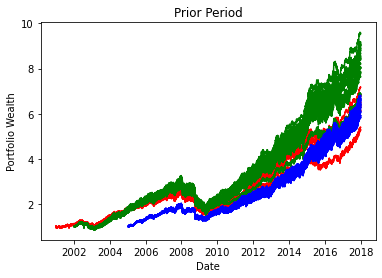

Prior Period
legend for above graph:
[253, 506, 1265]
['red', 'green', 'blue']
mean final cumulative returns:
[6.264587617793949, 8.303054426016972, 6.354640715403859]
counts:
[16, 30, 39]


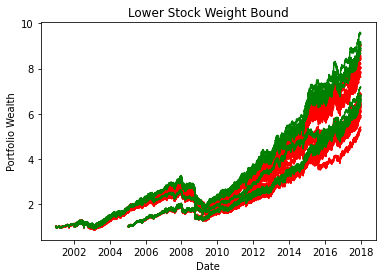

Lower Stock Weight Bound
legend for above graph:
[-0.003, -0.002, -0.001]
['red', 'green', 'blue']
mean final cumulative returns:
[6.85789612222784, 7.427290209291695, 0]
counts:
[60, 25, 0]


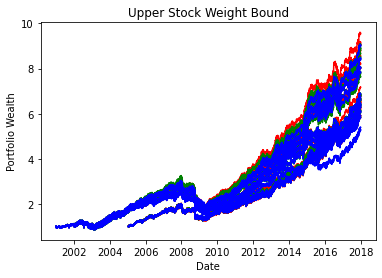

Upper Stock Weight Bound
legend for above graph:
[0.1, 0.2, 0.3]
['red', 'green', 'blue']
mean final cumulative returns:
[7.120363116751026, 7.08451593780719, 6.853911861686731]
counts:
[27, 32, 26]


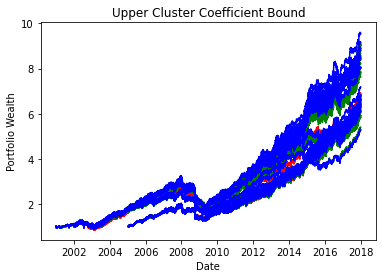

Upper Cluster Coefficient Bound
legend for above graph:
[2, 3, 4]
['red', 'green', 'blue']
mean final cumulative returns:
[6.481242378440604, 7.005652419601769, 7.209972609185013]
counts:
[12, 34, 39]


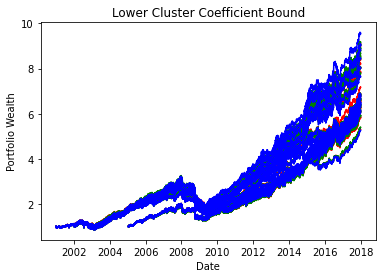

Lower Cluster Coefficient Bound
legend for above graph:
[-0.02, -0.05, -0.1]
['red', 'green', 'blue']
mean final cumulative returns:
[6.859986831415403, 7.151811774064845, 7.037063582944284]
counts:
[27, 33, 25]


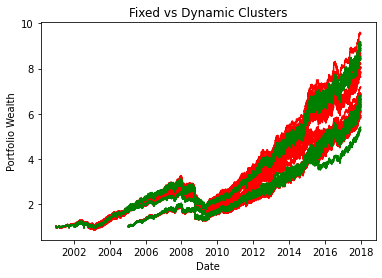

Fixed vs Dynamic Clusters
legend for above graph:
[50, None]
['red', 'green']
mean final cumulative returns:
[6.997961298507745, 7.068546516471517]
counts:
[52, 33]


In [41]:
for i in range(len(iter_params)):
    means = []
    cts = []
    for j in range(len(iter_params[i])):
        mean_calc = 0
        mean_count = 0
        for k in res_new.keys():
            if isinstance(k[iter_ind[i]],tuple):
                if (k[iter_ind[i]][0] == iter_params[i][j]) or (k[iter_ind[i]][1] == iter_params[i][j]):
                    plt.plot(res_new[k],color=colors[j])
                    mean_calc += res_new[k][-1]
                    mean_count += 1
                    
            else:
                if (k[iter_ind[i]] == iter_params[i][j]):
                    plt.plot(res_new[k],color=colors[j])
                    mean_calc += res_new[k][-1]
                    mean_count += 1
        cts.append(mean_count)
        if mean_count != 0:
            means.append(mean_calc/mean_count)
        else:
            means.append(0)
    plt.title(iter_names[i])
    plt.xlabel('Date')
    plt.ylabel('Portfolio Wealth')
    plt.show()
    print(iter_names[i])
    print('legend for above graph:')
    print(iter_params[i])
    print(colors[:len(iter_params[i])])
    print('mean final cumulative returns:')
    print(means)
    print('counts:')
    print(cts)

In [42]:
for i in range(len(iter_params)):
    means = []
    ct = 0
    for j in range(len(iter_params[i])):
        mean_calc = 0
        mean_count = 0
        for k in res_new.keys():
            if isinstance(k[iter_ind[i]],tuple):
                if (k[iter_ind[i]][0] == iter_params[i][j]) or (k[iter_ind[i]][1] == iter_params[i][j]):
                    print(k)
                    ct += 1
            else:
                if (k[iter_ind[i]] == iter_params[i][j]):
                    print(k)
                    ct += 1
                    
    print('legend for above graph:')
    print('count =',ct)
    print(iter_params[i])
    print(colors[:len(iter_params[i])])
    print('mean final cumulative returns:')
    print(means)

(63, 253, 63, False, (-0.002, 0.3), 4, -0.02, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.2), 4, -0.1, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.3), 3, -0.02, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.3), 4, -0.1, 0.75, 0.05, None, True)
(63, 253, 63, False, (-0.002, 0.2), 4, -0.02, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.2), 3, -0.1, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.3), 3, -0.1, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.3), 3, -0.05, 0.75, 0.05, None, True)
(63, 253, 63, False, (-0.002, 0.1), 4, -0.02, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.002, 0.2), 4, -0.05, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.3), 3, -0.05, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.3), 4, -0.1, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.2), 4, -0.02, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.1), 3, -0.02, 0.75, 0.05, 50, True)
(63, 253, 63, False, (-0.003, 0.1), 3, -0.1, 0.75

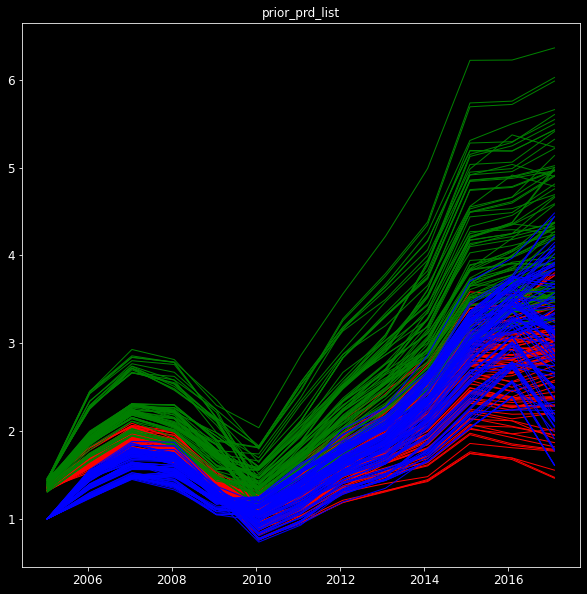

legend for above graph:
[253, 506, 1265]
['red', 'green', 'blue']
mean final cumulative returns:
[2.7562567154126625, 4.362399308965026, 3.023106751552685]


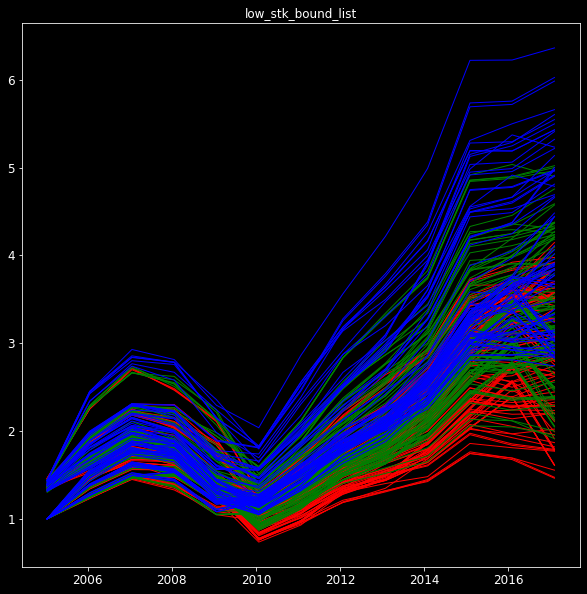

legend for above graph:
[-0.007, -0.005, -0.003]
['red', 'green', 'blue']
mean final cumulative returns:
[2.810213768983104, 3.3019531424224184, 3.9792318155874975]


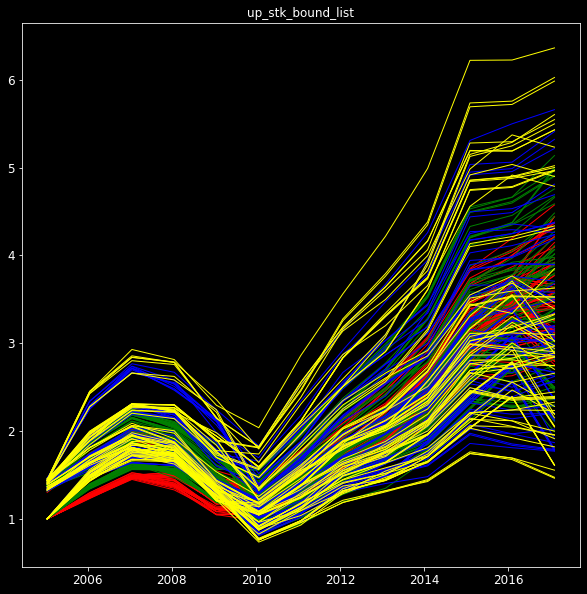

legend for above graph:
[0.01, 0.02, 0.05, 0.1]
['red', 'green', 'blue', 'yellow']
mean final cumulative returns:
[3.511212452659798, 3.4458204672618593, 3.1396842538156675, 3.2448044339933184]


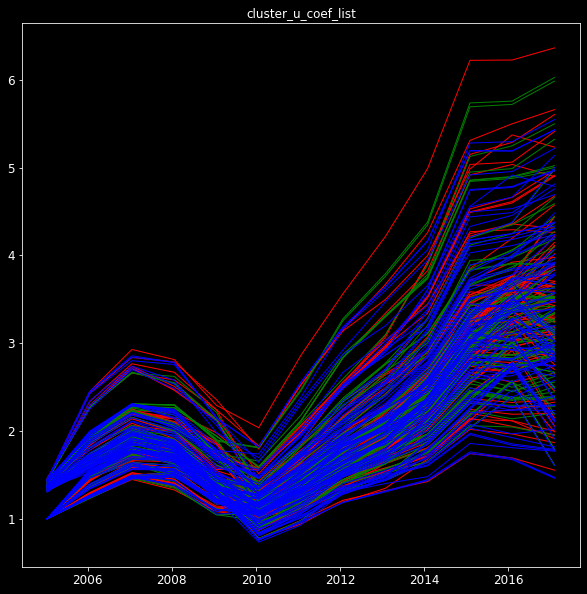

legend for above graph:
[2, 3, 5]
['red', 'green', 'blue']
mean final cumulative returns:
[3.425062263202145, 3.301224258308056, 3.3097133440503965]


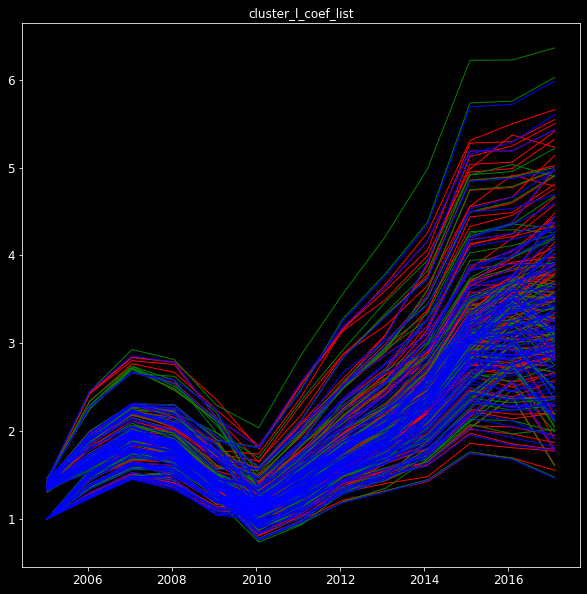

legend for above graph:
[-0.02, -0.05, -0.1]
['red', 'green', 'blue']
mean final cumulative returns:
[3.4405515692036834, 3.279425207662715, 3.2825958036915406]


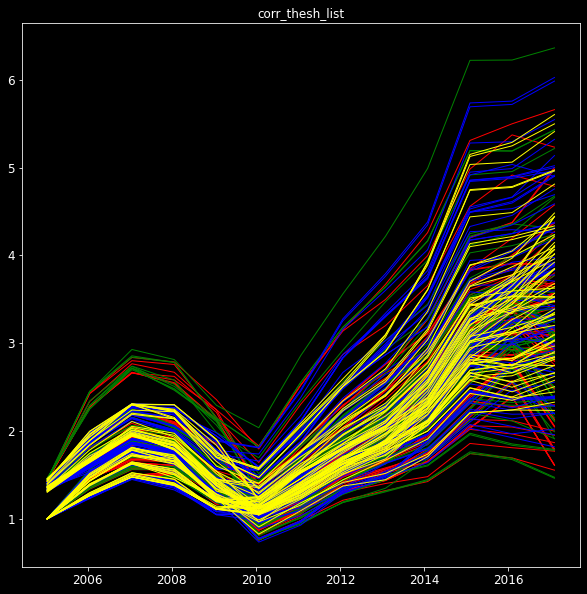

legend for above graph:
[0.5, 0.6, 0.7, 0.8]
['red', 'green', 'blue', 'yellow']
mean final cumulative returns:
[3.0575953180097235, 3.1100013938383024, 3.6108265297951756, 3.613086890264762]


In [13]:
for i in range(len(iter_params)):
    means = []
    for j in range(len(iter_params[i])):
        mean_calc = 0
        mean_count = 0
        for k in ret_253.keys():
            if k[iter_ind[i]] == iter_params[i][j]:
                plt.plot(ret_253[k],color=colors[j])
                mean_calc += ret_253[k][-1]
                mean_count += 1
        means.append(mean_calc/mean_count)
    plt.title(iter_names[i])
    plt.show()
    print('legend for above graph:')
    print(iter_params[i])
    print(colors[:len(iter_params[i])])
    print('mean final cumulative returns:')
    print(means)